In [1]:
import io
import os
import cv2
import ast
import time
import imagehash
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from PIL import Image

In [2]:
from utils.visualization import display_images

In [3]:
from google.cloud import vision
from google.oauth2 import service_account

## Goals

> <font size=4> The goals of preprocessing - delete possible duplicates and generate weak labels based on the data itself.  </font>

> <font size=4> I will proceed from hypothesis that logo is something popular, so it can be represented in the data more one times. Of course, new logos could be difficult to detect using this approach, but as the very first step I should check that. And that task strontly connected to the duplicates elimination - as main preprocessing step before training models. </font>

> <font size=4> Because duplicates in the dataset with different names could lead to data leakage, ambigous labels and overfitting in the very edge cases. </font>

> <font size=4> Also I should try to generate weak labels from the data to train model classifier. I don't think this problem can be fully solved via unsupervised methods, because discrimination between real and fake logos is subjective process and requires at least approximate labels. The most prominent approach here is <b> semi-supervised learning (SSL) </b>, when we have a lot of unlabeled data and the small percentage of real or approximate labels. These requirments allows to use typical deep learning classification models with modified semi-supervised pipeline. </b> </font>

## Preprocessing steps

> <font size=4> 1) Find duplicates using perceptual hash similary 
    <br> 2) Filter duplicates, compute number of occurences
    <br> 3) Use number of occurences > 1 as condition to be "true" labeled 
    <br> 4) Use Google API Logo Detection and label 1000 images 
</font>

## Metric discussion

> <font size=4> The resulted model should have low number of <b> False Positives </b>, so it leads to <b> Precision = $\frac{TP}{TP+FP} \rightarrow \max$ </b>. However, we don't have any true label, except of weak labels that we can extract from the data. In this case, high precision over weak labels couldn't give guarantess model will give correct results. 
<br>
<br>
That why I labeled 2014 images from dataset and will use it for validation of semi-supervised pipeline (and I don't use it for training). 
</font>

> <font size=4> I didn't use any other datasets with logos, because, here we have a lot of misdetections in the images and a lot of different logos as well. Typical datasets like <b> WebLogo-2M </b> has only 194 logos, so I think very little compared to this dataset (I think so after visualization of data). So my decision to mark part of the data for validation will simplify process of final testing of the different methods.
</font>

# Part 1

In [12]:
DATASET_FOLDER = "test_task_logo_dataset"

In [13]:
# get all images, create csv dataframe with images

files = next(os.walk(DATASET_FOLDER))[2]
files = list(filter(lambda x: x.endswith("jpg"), files))
files = list(map(lambda x: os.path.join(DATASET_FOLDER, x), files))
files = np.array(files)

df = pd.DataFrame([])
df["path"] = files
# compute perceptual hash of images
df["hash"] = df["path"].apply(lambda x: str(imagehash.phash(Image.open(x))))

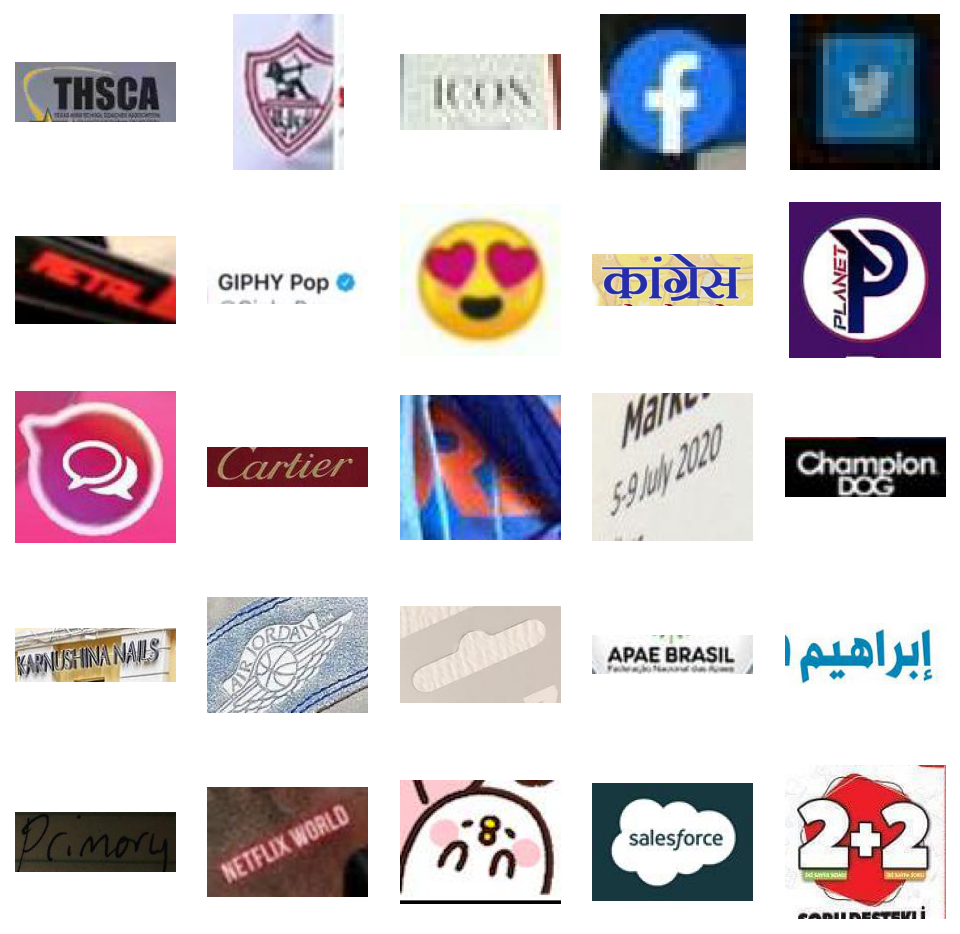

In [43]:
display_images(df, 5, 5)

> <font size=4> Suppose model will return $1.0$ score for every image: $f(x) = 1$. Using random images visualization, we can estimate approximate precision of such model and set it as "benchmark" to compare with future classifier. I counted myself false positives few runs of images displaying and called it visual Precision:
    <center> $vPrecision = 73.5\%$ </center>
However, it's very optimistic estimate, because computed precision from the labeled part gives:
    <center> $Precision = 37.93\%$ </center>
So I will use the $37.93\%$ as baseline that I should increase with some methods.
</font>

> <font size=4> How quickly compute similarity between images in entire dataset? I decided to use perceptual hash for this task. It's very fast, doesn't use any pretrained model and can find approximate duplicates. 
<br> <br> Perceptual hash over input image generates 8x8 boolean descriptor. If images are similar their boolean descriptors will be similar and hence have low or zero element-wise distance - chose threshold $T$ and get images with distance $<T$.
<br> 
<br> $A,\ B \in {\{0,\ 1\}}^{8\times8}$ with distance $d(A,\ B)=\sum_{ij} |a_{ij} - b_{ij}| \in \{0,...,64\}$
<br> Via linear transformation $2x + 1$ applyied to the matrices, elements are transformed from $\{0,\ 1\}$ to $\{-1,\ 1\}$, we can construct functional using Einstein summation notation to compute similarities. In this case, similar images should have similarity score $>T$.
<br>
<br> $A,\ B \in {\{-1,\ 1\}}^{8\times8}$ with similarity $s(A,\ B)=\sum_{ij} a_{ij}b_{ij} \in \{-64, ..., 64\}$ 
</font>

In [87]:
def compute_groups(hashes, threshold=50):
    """
    Finds similar images using perceptual hash
    similarity as matching criteria
    
    Parameters
    ----------
    hashes : pd.Series
        Pandas series of hashes
    threshold : int
        Threshold determines match between
        two 8x8 boolean perceptual hashes
            
    Returns
    -------
    groups : list
        List of lists with indexes of similar
        images, e.g [[0], [1, 35], ...]
    """
    # get hashes as int8 array - (N, 8) shape
    hashes = hashes.apply(lambda x: 2 * imagehash.hex_to_hash(x).hash.astype(np.int8) - 1)
    hashes = np.array(hashes.tolist())
    # compute similarity using einstein formalism - resulted in (N, N) matrix
    matrix = np.einsum("kij,mij->km", hashes, hashes)
    # group values
    groups = map(lambda x: list(np.where(x > threshold)[0]), list(matrix))
        
    return groups

In [15]:
groups = compute_groups(df.hash)

In [16]:
df["group"] = -1
with tqdm(ascii=True, leave=False, total=len(df)) as bar:
    for i, group in enumerate(groups):
        # if any element of a group has no similar
        # assign it label to this group
        if (df["group"].loc[group] == -1).any():
            df.loc[group, "group"] = i
        bar.update()

In [271]:
df.to_csv("datasets/dataset_full.csv", index=False)

In [22]:
# compute number of elements in each group
counts = df.groupby("group").count().reset_index()[["group", "path"]]
counts = counts.rename(columns={"path": "n_images"})

# get only one image from each group
clean = df.groupby("group").apply(lambda g: g["path"].iloc[0]).reset_index()
clean = clean.rename(columns={0: "path"})

# merge based on group id
clean = clean.merge(counts, how="inner", on="group")
clean.to_csv("datasets/dataset.csv", index=False)

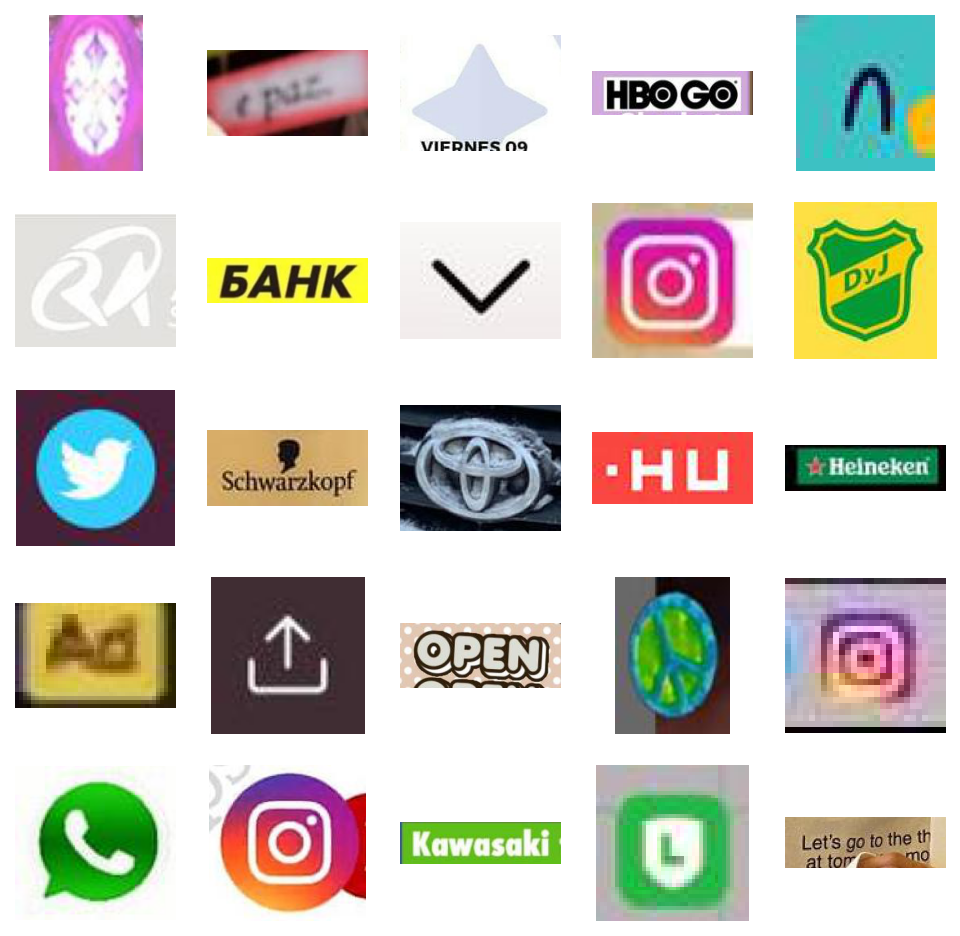

In [48]:
display_images(clean[clean.n_images > 1], 5, 5)

> <font size=4> Seems like very noisy, but for the first step will be okay.
</font>

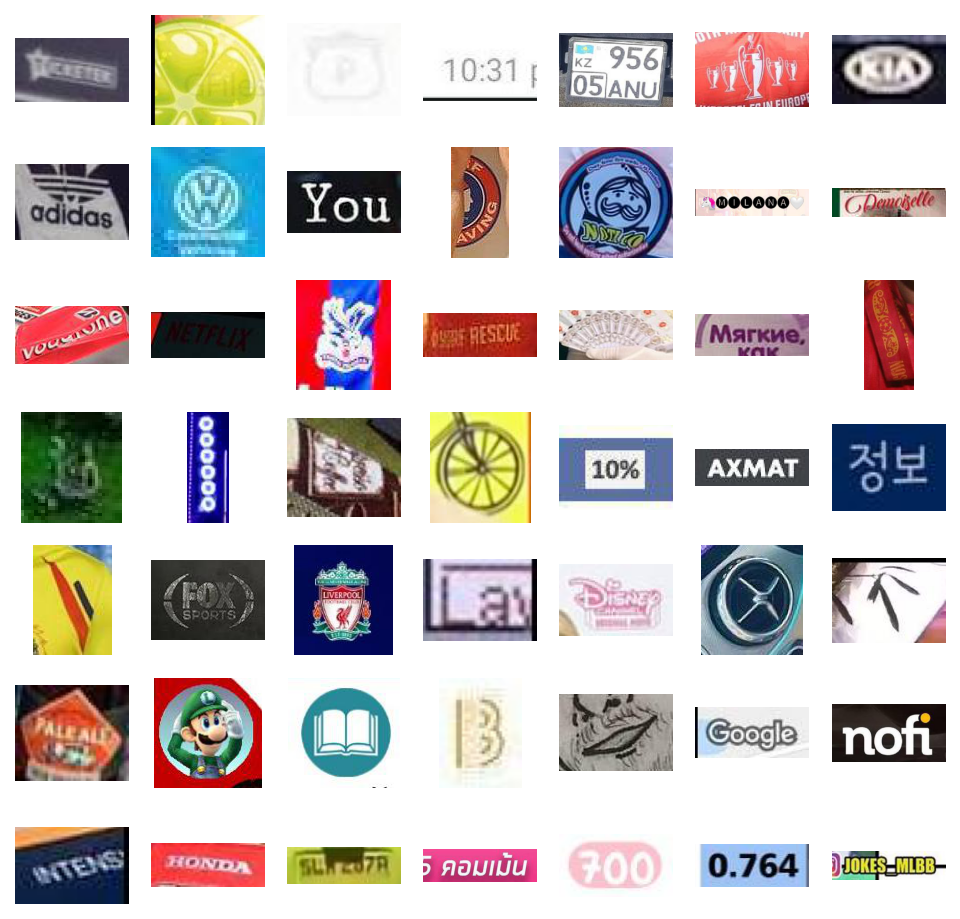

In [99]:
display_images(df.iloc[:-200], 7, 7)

## Google API

> <font size=4> I tried to use Python Google API Logo Detection to collect additional, more robust, labels. It allows free tier in 1000 labels per month, so I used it. 
</font>

In [24]:
df = pd.read_csv("datasets/dataset.csv")

In [29]:
credentials = service_account.Credentials.from_service_account_file('/Users/vaden4d/Downloads/creds.json')
client = vision.ImageAnnotatorClient(credentials=credentials)

In [30]:
with tqdm(ascii=True, leave=False, total=1000) as bar:
    for index, row in df.iloc[-1000:].iterrows():
        path = row.path

        with io.open(path, 'rb') as image_file:
            content = image_file.read()
        image = vision.Image(content=content)
        response = client.logo_detection(image=image)

        try:
            df.loc[index, "api_score"] = response.logo_annotations[0].score
            df.loc[index, "api_name"] = response.logo_annotations[0].description
        except Exception as e:
            df.loc[index, "api_score"] = 0.0
            df.loc[index, "api_name"] = "no_logo"

        time.sleep(0.2)
        
        bar.update()

In [34]:
df

group                                               path  n_images  \
0          0  test_task_logo_dataset/a7ee2ad0-f27a-4189-9207...         1   
1          1  test_task_logo_dataset/a3ff6c0b-1aa2-4fb2-be20...         1   
2          2  test_task_logo_dataset/e2524a86-a652-4181-90c4...         1   
3          3  test_task_logo_dataset/f0b3e6ef-f025-471c-942e...         2   
4          4  test_task_logo_dataset/42b000e9-4346-486b-b3d6...         1   
...      ...                                                ...       ...   
32153  36240  test_task_logo_dataset/4809662e-1d0e-4a25-a721...         1   
32154  36241  test_task_logo_dataset/64108cf4-9d72-4003-a8f9...         1   
32155  36242  test_task_logo_dataset/e5110399-79a9-4864-8227...         1   
32156  36243  test_task_logo_dataset/2c955ab4-89ad-41fd-8422...         1   
32157  36244  test_task_logo_dataset/fd017c12-c8a4-444f-a2bf...         1   

       api_score             api_name  
0      -1.000000                   -1  
1      -1.000000                   -1  
2      -1.000000                   -1  
3      -1.000000                   -1  
4      -1.000000                   -1  
...          ...                  ...  
32153   0.586603  Polish Press Agency  
32154   0.000000              no_logo  
32155   0.000000              no_logo  
32156   0.936305               Amazon  
32157   0.000000              no_logo  

[32158 rows x 5 columns]

In [41]:
df.to_csv("datasets/dataset_with_labels.csv", index=False)

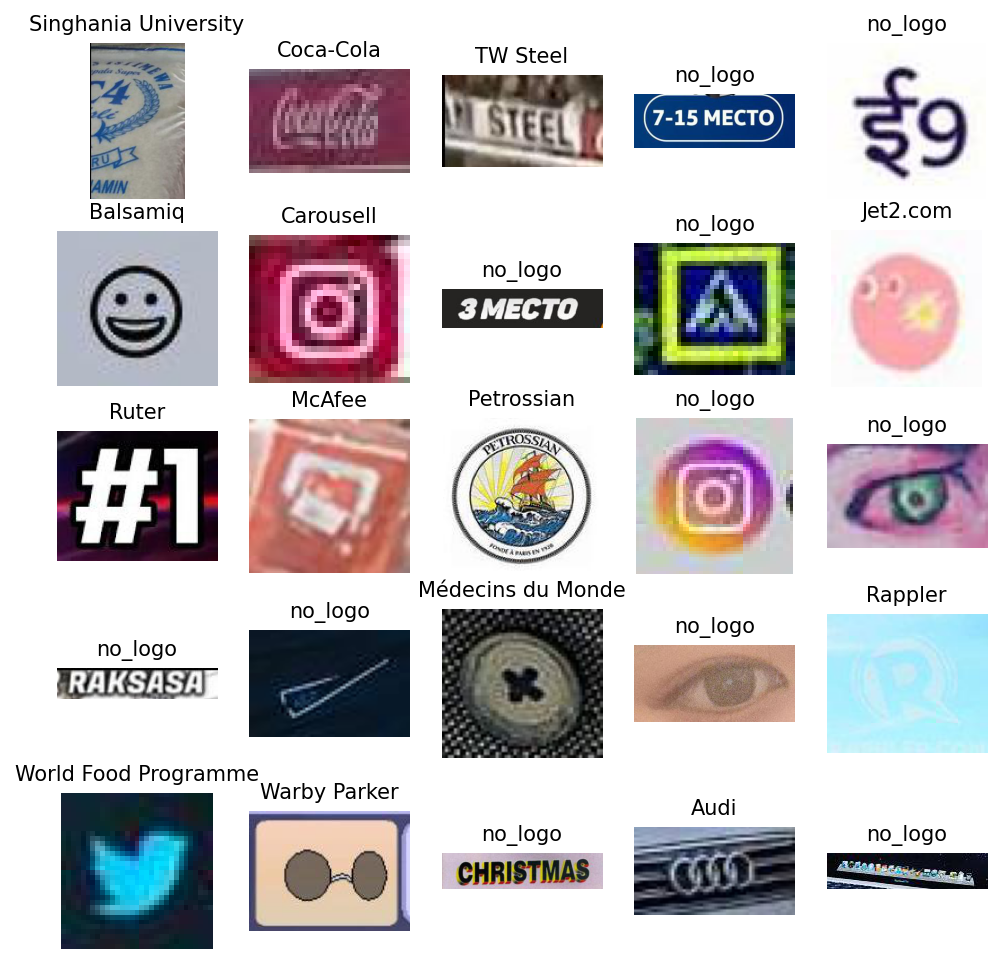

In [37]:
display_images(df[df.api_score > -1], 5, 5, title_column="api_name")

> <font size=4> Via visual inspection of precision using random samples from 1000 labeled images, I computed approximate precision of Google API: $Precision = 39.6%$. It's very low, so I decided don't use its positive predictions. However, I observed that if model doesn't predict logo, it looks reliable enough. So I decided to use its negative predictions as weak labels for negative class.
</font>

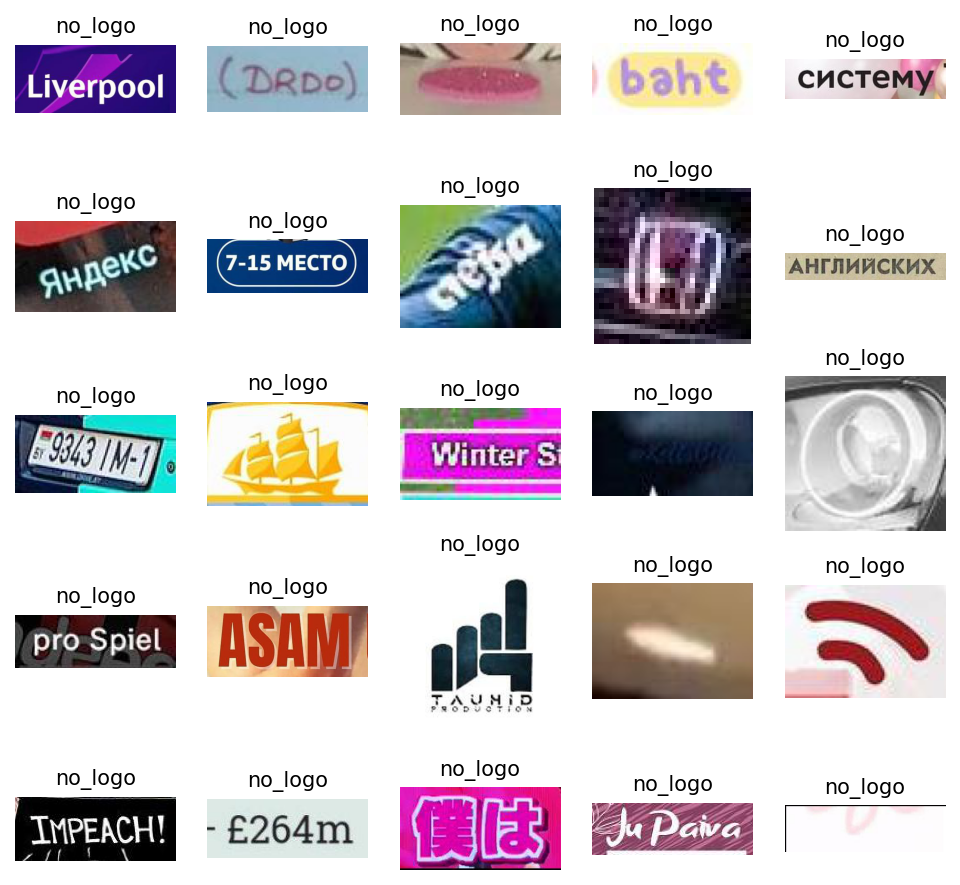

In [40]:
display_images(df[df.api_name == "no_logo"], 5, 5, title_column="api_name")

In [49]:
df[df.api_name == "no_logo"]

group                                               path  n_images  \
31158  35047  test_task_logo_dataset/766c2009-0049-4eb3-a89a...         1   
31159  35048  test_task_logo_dataset/b0f9fed4-892a-4c3e-b24a...         1   
31160  35049  test_task_logo_dataset/8860d957-9d87-4958-ac27...         1   
31161  35050  test_task_logo_dataset/7c247fcb-3786-45ab-8601...         1   
31163  35053  test_task_logo_dataset/eb1b0c94-b894-4a45-bca2...         1   
...      ...                                                ...       ...   
32151  36238  test_task_logo_dataset/43a483b3-c867-4e4a-90c2...         1   
32152  36239  test_task_logo_dataset/1d29ffeb-459d-4587-8470...         1   
32154  36241  test_task_logo_dataset/64108cf4-9d72-4003-a8f9...         1   
32155  36242  test_task_logo_dataset/e5110399-79a9-4864-8227...         1   
32157  36244  test_task_logo_dataset/fd017c12-c8a4-444f-a2bf...         1   

       api_score api_name  
31158        0.0  no_logo  
31159        0.0  no_logo  
31160        0.0  no_logo  
31161        0.0  no_logo  
31163        0.0  no_logo  
...          ...      ...  
32151        0.0  no_logo  
32152        0.0  no_logo  
32154        0.0  no_logo  
32155        0.0  no_logo  
32157        0.0  no_logo  

[369 rows x 5 columns]

In [51]:
df["weak_label"] = df.apply(lambda x: 0 if x.api_name == "no_logo" else 1 if x.n_images > 1 else -1, axis=1)
df.to_csv("datasets/dataset_with_weakly_labels.csv")

### So, as the result, I use dataset with weak labels for supervised and semi-supervised settings. 

# Part 2

> <font size=4> I desided to boost labels based on the perceptual hash similarity and Google API score with additional information - about image entropy and its possible text on the image. Because, during my exploration of the dataset, I noticed few the most popular misdetections: 
<br>
<br> 1) Text over single-colored background - not logo, it has text and probably low entropy
<br> 2) Random crops like elements of cars, real world - possibly has high entropy
<br> 3) Text from images can give additional information
</font>

In [2]:
import cv2
import pytesseract
from pytesseract import Output
from scipy.stats import entropy

In [60]:
df = pd.read_csv("ocr.csv")
df.ocr = df.ocr.apply(ast.literal_eval)

In [61]:
def compute_entropy(img):
    """
    Computes entropy for each channel of RGB image
    
    Parameters
    ----------
    img : np.ndarray
        Image represented as (H, W, 3) array
            
    Returns
    -------
    entropy(r), entropy(g), entropy(b) : float
        Entropy of each channels
    """
    r, _ = np.histogram(img[..., 0], bins=255)
    g, _ = np.histogram(img[..., 1], bins=255)
    b, _ = np.histogram(img[..., 2], bins=255)
    return entropy(r), entropy(g), entropy(b)

In [62]:
df["entropy_r"] = 0
df["entropy_g"] = 0
df["entropy_b"] = 0
df["h"] = 0
df["w"] = 0

with tqdm(ascii=True, leave=False, total=len(df)) as bar:

    for index, row in df.iterrows():
        
        img = np.array(Image.open(row.path))
        r, g, b = compute_entropy(img)
        df.loc[index, "entropy_r"] = r
        df.loc[index, "entropy_g"] = g
        df.loc[index, "entropy_b"] = b
        df.loc[index, "h"] = img.shape[0]
        df.loc[index, "w"] = img.shape[1]

        bar.update()
            
df["entropy"] = (df["entropy_r"] + df["entropy_g"] + df["entropy_b"]) / 3.0
df = df.sort_values(by="entropy")

> <font size=4> After this step I executed OCR extraction in the Google Colab, so from here dataframe has an additional column <b> ocr </b>.
</font>

In [28]:
df[df.entropy > df.entropy.quantile(q=0.99)]

Unnamed: 0  group                                               path  \
24476       24476  27147  test_task_logo_dataset/1b9b390a-e6d7-4857-95d7...   
14104       14104  15186  test_task_logo_dataset/8dc070c7-9053-4af5-b7fe...   
7744         7744   8212  test_task_logo_dataset/bc9a611b-474f-46cc-b4e5...   
4457         4457   4677  test_task_logo_dataset/768825ee-ead2-48ae-8083...   
28591       28591  32003  test_task_logo_dataset/474b1ffd-2cc1-4644-96b9...   
...           ...    ...                                                ...   
12088       12088  12960  test_task_logo_dataset/b48faaad-48a5-479b-a38a...   
25945       25945  28866  test_task_logo_dataset/22f31592-ee02-461c-b01f...   
24922       24922  27669  test_task_logo_dataset/2deca010-08b8-4f9d-bddf...   
19858       19858  21724  test_task_logo_dataset/8d7fa911-3b16-419e-b82e...   
13686       13686  14732  test_task_logo_dataset/ebff7b75-f7b6-459e-b282...   

       n_images  api_score api_name  weak_label                       ocr  \
24476         1       -1.0       -1          -1                        []   
14104         1       -1.0       -1          -1                        []   
7744          1       -1.0       -1          -1                        []   
4457          1       -1.0       -1          -1                        []   
28591         1       -1.0       -1          -1                        []   
...         ...        ...      ...         ...                       ...   
12088         1       -1.0       -1          -1    [('', (0, 0, 0, 607))]   
25945         1       -1.0       -1          -1                        []   
24922         1       -1.0       -1          -1                        []   
19858         1       -1.0       -1          -1                        []   
13686         1       -1.0       -1          -1  [('', (0, 0, 175, 108))]   

       entropy_r  entropy_g  entropy_b    h     w   entropy  
24476   5.335217   5.337528   5.311017   38    80  5.327921  
14104   5.391945   5.321680   5.270761   57    60  5.328128  
7744    5.265150   5.343976   5.375451  103    56  5.328193  
4457    5.328251   5.329780   5.326611   56    58  5.328214  
28591   5.364165   5.349623   5.271290  110    96  5.328359  
...          ...        ...        ...  ...   ...       ...  
12088   5.388961   5.464780   5.526125  607  1151  5.459955  
25945   5.468097   5.468962   5.467702   58   122  5.468254  
24922   5.446546   5.473996   5.490587   80    90  5.470376  
19858   5.468868   5.472851   5.477188   77    53  5.472969  
13686   5.490151   5.453237   5.486332  108   175  5.476573  

[322 rows x 14 columns]

In [36]:
df[(df.ocr != '[]')]

Unnamed: 0  group                                               path  \
30505       30505  34268  test_task_logo_dataset/30230c74-6a4e-4a41-bd01...   
19890       19890  21762  test_task_logo_dataset/3cb6a4fb-a5dc-43da-871b...   
79             79     82  test_task_logo_dataset/df739121-944d-45e4-83bd...   
27800       27800  31043  test_task_logo_dataset/8dc57f2f-975d-4afd-b490...   
6480         6480   6848  test_task_logo_dataset/e18507a0-c408-428d-b844...   
...           ...    ...                                                ...   
6236         6236   6584  test_task_logo_dataset/621ec1f0-392c-4041-acaf...   
22497       22497  24793  test_task_logo_dataset/073343ce-d29a-4b24-af6f...   
16995       16995  18444  test_task_logo_dataset/e43354f0-407f-4ab4-af9a...   
12088       12088  12960  test_task_logo_dataset/b48faaad-48a5-479b-a38a...   
13686       13686  14732  test_task_logo_dataset/ebff7b75-f7b6-459e-b282...   

       n_images  api_score api_name  weak_label  \
30505         1       -1.0       -1          -1   
19890         1       -1.0       -1          -1   
79            1       -1.0       -1          -1   
27800         1       -1.0       -1          -1   
6480          1       -1.0       -1          -1   
...         ...        ...      ...         ...   
6236          1       -1.0       -1          -1   
22497         1       -1.0       -1          -1   
16995         1       -1.0       -1          -1   
12088         1       -1.0       -1          -1   
13686         1       -1.0       -1          -1   

                                                     ocr  entropy_r  \
30505                         [('fi', (70, 18, 18, 26))]   1.064124   
19890                         [('10%', (17, 19, 23, 9))]   1.119453   
79                             [('»', (51, 27, 45, 52))]   1.243734   
27800  [('     ', (44, 0, 363, 134)), (' ', (445, 110...   0.989292   
6480                            [('S', (0, 16, 93, 92))]   1.058326   
...                                                  ...        ...   
6236                             [('', (0, 0, 132, 42))]   5.423659   
22497                           [('', (0, 0, 132, 162))]   5.442437   
16995                           [('', (0, 0, 120, 115))]   5.468872   
12088                             [('', (0, 0, 0, 607))]   5.388961   
13686                           [('', (0, 0, 175, 108))]   5.490151   

       entropy_g  entropy_b    h     w   entropy  
30505   0.856394   1.064124   62   188  0.994881  
19890   1.119453   1.119453   39    60  1.119453  
79      1.226790   1.191934  108   141  1.220819  
27800   1.441755   1.651524  266   454  1.360857  
6480    1.293013   1.794793  108    93  1.382044  
...          ...        ...  ...   ...       ...  
6236    5.479705   5.424971   42   132  5.442778  
22497   5.465940   5.432988  162   132  5.447122  
16995   5.460965   5.431633  115   120  5.453823  
12088   5.464780   5.526125  607  1151  5.459955  
13686   5.453237   5.486332  108   175  5.476573  

[10727 rows x 14 columns]

In [67]:
df[df.api_score > 0.7]

Unnamed: 0  group                                               path  \
31977       31977  36039  test_task_logo_dataset/0a753f19-5431-4ba5-bcce...   
31722       31722  35721  test_task_logo_dataset/ed09627d-b399-4be5-ad72...   
31585       31585  35561  test_task_logo_dataset/525037fe-82ff-48cb-a0a8...   
31623       31623  35606  test_task_logo_dataset/1cb8e17e-1c6a-49c4-b9fc...   
31999       31999  36064  test_task_logo_dataset/d46beed5-a44e-4f6e-a75f...   
...           ...    ...                                                ...   
31431       31431  35372  test_task_logo_dataset/e48a03d7-0e65-4fb8-9a74...   
31248       31248  35153  test_task_logo_dataset/b6af3a8d-89bb-4c6a-a254...   
31982       31982  36045  test_task_logo_dataset/f91b38ce-0c84-47d5-97e4...   
31787       31787  35803  test_task_logo_dataset/25cf8da6-a618-4354-9416...   
31283       31283  35198  test_task_logo_dataset/c0151821-4801-4c41-9ba7...   

       n_images  api_score           api_name  weak_label  \
31977         1   0.829048          Secretlab          -1   
31722         1   0.857459        Czech Radio          -1   
31585         1   0.737849  Gas Safe Register          -1   
31623         1   0.968081          Visa Inc.          -1   
31999         1   0.944741     Santander Bank          -1   
...         ...        ...                ...         ...   
31431         1   0.963498      Ben & Jerry's          -1   
31248         1   0.819126            Kit Kat          -1   
31982         1   0.809999            Castrol          -1   
31787         1   0.751576            La Liga          -1   
31283         1   0.962751             Toyota          -1   

                                                 ocr  entropy_r  entropy_g  \
31977                                             []   1.761039   1.761039   
31722                                             []   1.998935   1.998935   
31585  [(Sat, (18, 16, 28, 15)), (, (0, 44, 61, 1))]   1.918528   1.954471   
31623                                             []   2.149106   2.084672   
31999                         [(, (11, 0, 153, 52))]   2.106873   2.641687   
...                                              ...        ...        ...   
31431                     [(ate., (63, 80, 45, 19))]   5.294412   5.252222   
31248                                             []   5.383739   5.258531   
31982                                             []   5.361373   5.329003   
31787                           [(, (0, 0, 60, 74))]   5.380603   5.319126   
31283                                             []   5.346213   5.321667   

       entropy_b    h    w   entropy  
31977   1.761039   73   78  1.761039  
31722   1.998935   56   64  1.998935  
31585   2.168298   45   61  2.013766  
31623   2.216203  401  591  2.149993  
31999   2.798778   56  169  2.515779  
...          ...  ...  ...       ...  
31431   5.298975   99  332  5.281870  
31248   5.247514   80  130  5.296594  
31982   5.215405   34   99  5.301927  
31787   5.213046   74   60  5.304258  
31283   5.352011   77   74  5.339964  

[229 rows x 14 columns]

In [93]:
q = df.entropy.quantile(q=0.05)

In [92]:
def generate_weak_label(row, q):
    
    if row["api_name"] == "no_logo" or row["entropy"] < q:
        return 0
    elif row["n_images"] > 1:
        return 1
    else:
        return -1

In [95]:
df["weak_label_entropy"] = df.apply(lambda x: generate_weak_label(x, q), axis=1)

In [101]:
df.to_csv("dataset_with_weak_label_entropy.csv", index=False)

In [97]:
df.groupby("weak_label_entropy").count()

Unnamed: 0  group   path  n_images  api_score  api_name  \
weak_label_entropy                                                            
-1                       28443  28443  28443     28443      28443     28443   
 0                        1961   1961   1961      1961       1961      1961   
 1                        1754   1754   1754      1754       1754      1754   

                    weak_label    ocr  entropy_r  entropy_g  entropy_b      h  \
weak_label_entropy                                                              
-1                       28443  28443      28443      28443      28443  28443   
 0                        1961   1961       1961       1961       1961   1961   
 1                        1754   1754       1754       1754       1754   1754   

                        w  entropy  
weak_label_entropy                  
-1                  28443    28443  
 0                   1961     1961  
 1                   1754     1754

In [ ]:
labeled = pd.read_csv("dataset/labeled_part.csv")
weak = pd.read_csv("dataset/dataset_with_weak_label_entropy.csv")

weak = labeled[:1000].merge(weak, on="path", how="right")
weak["mixed_label"] = weak.apply(lambda x: 1 if x.label == "logo" else 0 if x.label == "no_logo" else x.weak_label_entropy, axis=1)
weak.to_csv("dataset/mixed.csv", index=False)

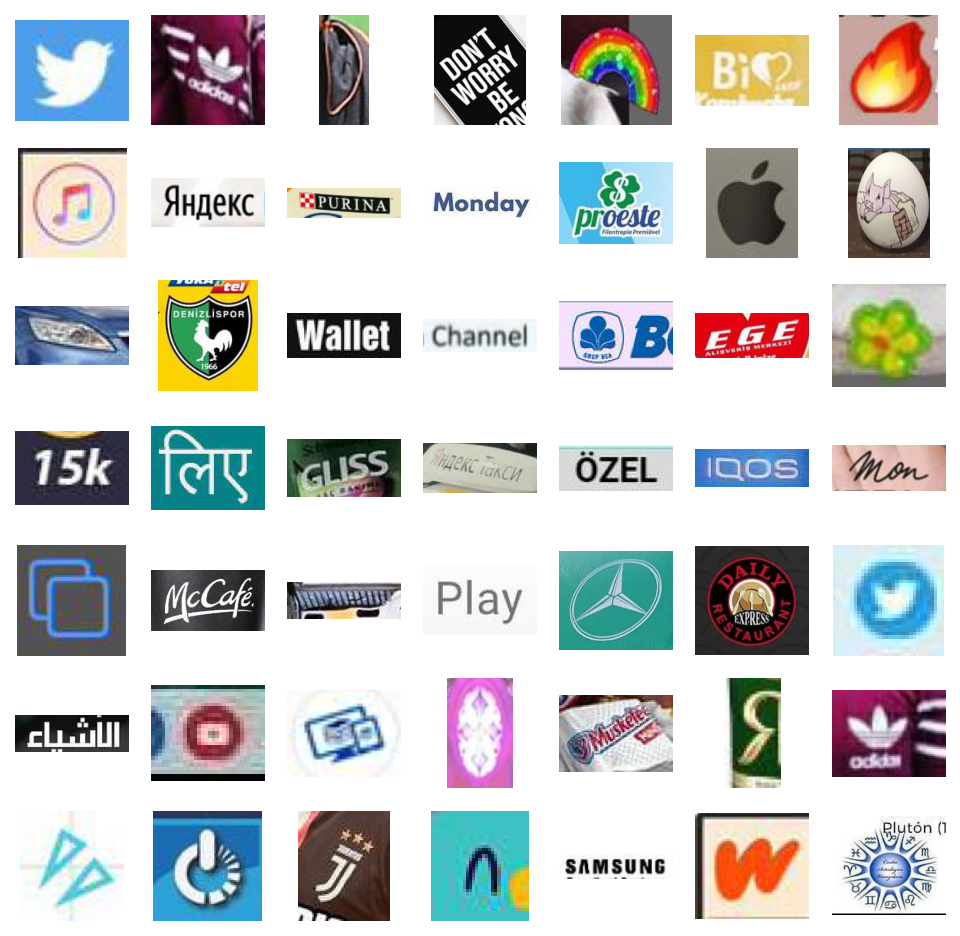

In [100]:
display_images(df[df.weak_label_entropy == 1], 7, 7)

In [69]:
df[(df.entropy > df.entropy.quantile(q=0.45)) & (df.entropy < df.entropy.quantile(q=0.55))]

Unnamed: 0  group                                               path  \
23493       23493  25960  test_task_logo_dataset/65673628-3f99-4c43-bae5...   
14169       14169  15258  test_task_logo_dataset/699435a4-ee63-44b4-8114...   
3176         3176   3316  test_task_logo_dataset/d8d5a233-a40c-4acf-b185...   
6697         6697   7075  test_task_logo_dataset/05ab2601-bf4e-4e3e-b39c...   
24572       24572  27259  test_task_logo_dataset/e22bbcae-591f-4239-9176...   
...           ...    ...                                                ...   
26394       26394  29392  test_task_logo_dataset/c7b1f5bd-5b2f-4a73-a546...   
30245       30245  33957  test_task_logo_dataset/a9deee99-1dd8-4a8a-8ae5...   
11880       11880  12735  test_task_logo_dataset/79cc327d-d509-43ec-a88e...   
10630       10630  11369  test_task_logo_dataset/0253be37-8a81-42b6-add4...   
1879         1879   1957  test_task_logo_dataset/f701374c-236a-41d3-abfc...   

       n_images  api_score api_name  weak_label                          ocr  \
23493         1       -1.0       -1          -1                           []   
14169         1       -1.0       -1          -1                           []   
3176          1       -1.0       -1          -1  [(Close, (16, 0, 169, 75))]   
6697          1       -1.0       -1          -1                           []   
24572         1       -1.0       -1          -1                           []   
...         ...        ...      ...         ...                          ...   
26394         1       -1.0       -1          -1                           []   
30245         1       -1.0       -1          -1                           []   
11880         1       -1.0       -1          -1                           []   
10630         1       -1.0       -1          -1      [(, (0, 14, 206, 142))]   
1879          1       -1.0       -1          -1                           []   

       entropy_r  entropy_g  entropy_b    h    w   entropy  
23493   4.375413   4.397909   4.515270   49   41  4.429531  
14169   4.383097   4.465817   4.439695   75   37  4.429536  
3176    3.937051   4.578558   4.773156   83  189  4.429588  
6697    4.487521   4.442410   4.359000   34  131  4.429643  
24572   4.411517   4.665574   4.212026   54   47  4.429706  
...          ...        ...        ...  ...  ...       ...  
26394   4.593893   4.546759   4.634288   49  125  4.591646  
30245   4.943807   4.452978   4.378289  144  189  4.591691  
11880   4.627928   4.608225   4.539067   40   43  4.591740  
10630   4.457937   4.537969   4.779414  156  206  4.591773  
1879    4.659987   4.553981   4.561449  107  143  4.591805  

[3216 rows x 14 columns]

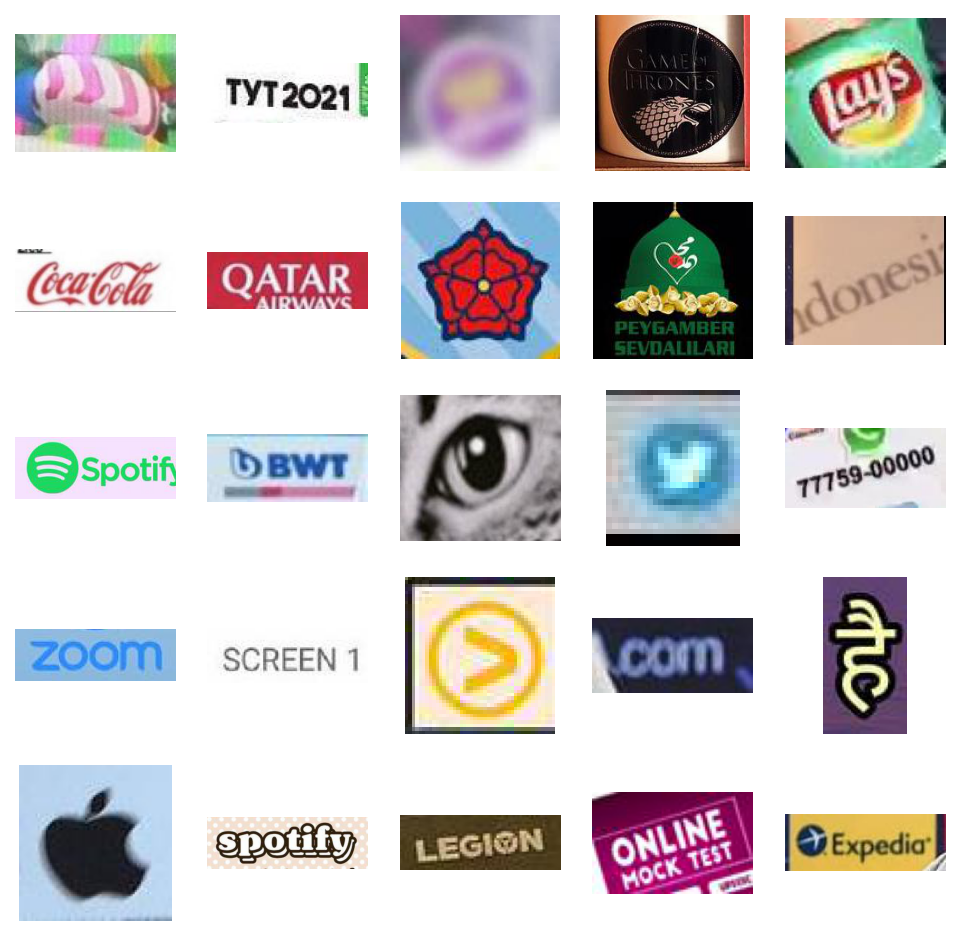

In [89]:
display_images(df[df.n_images > 1], 5, 5)

In [56]:
import ast

In [57]:
df = df.ocr.apply(lambda x: ast.literal_eval(x))

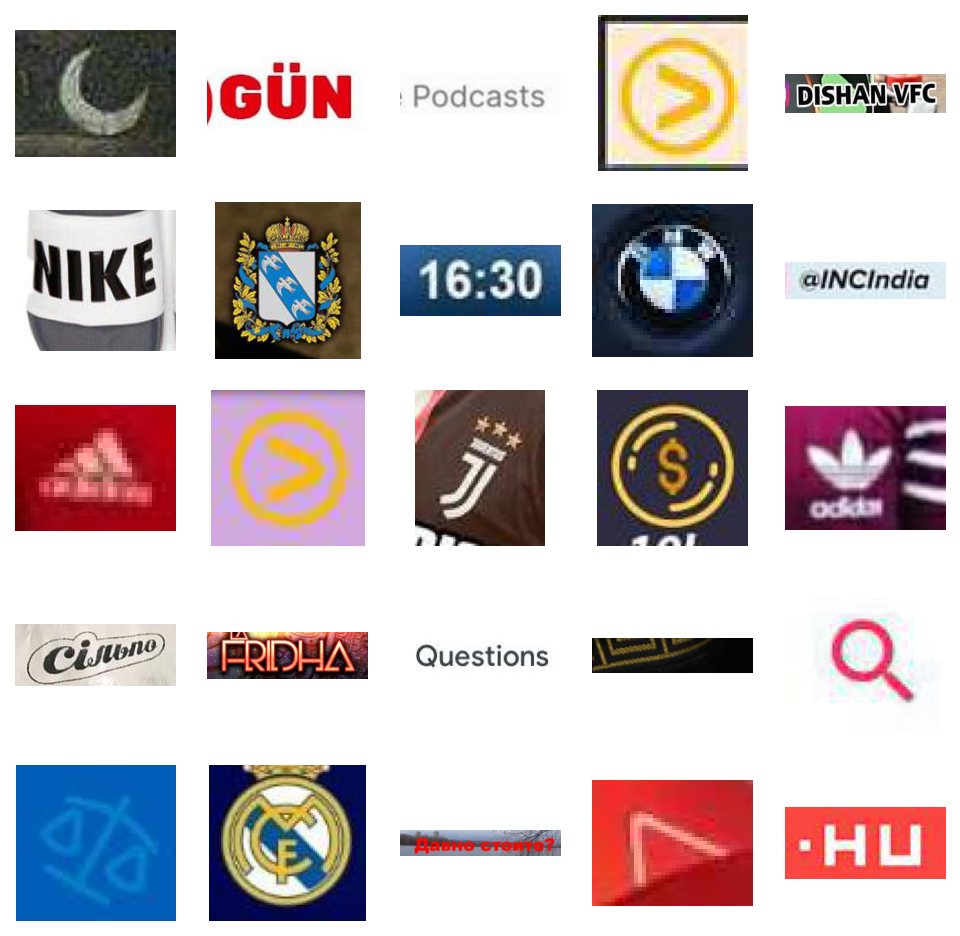

In [55]:
display_images(df[df.n_images > 1], 5, 5)

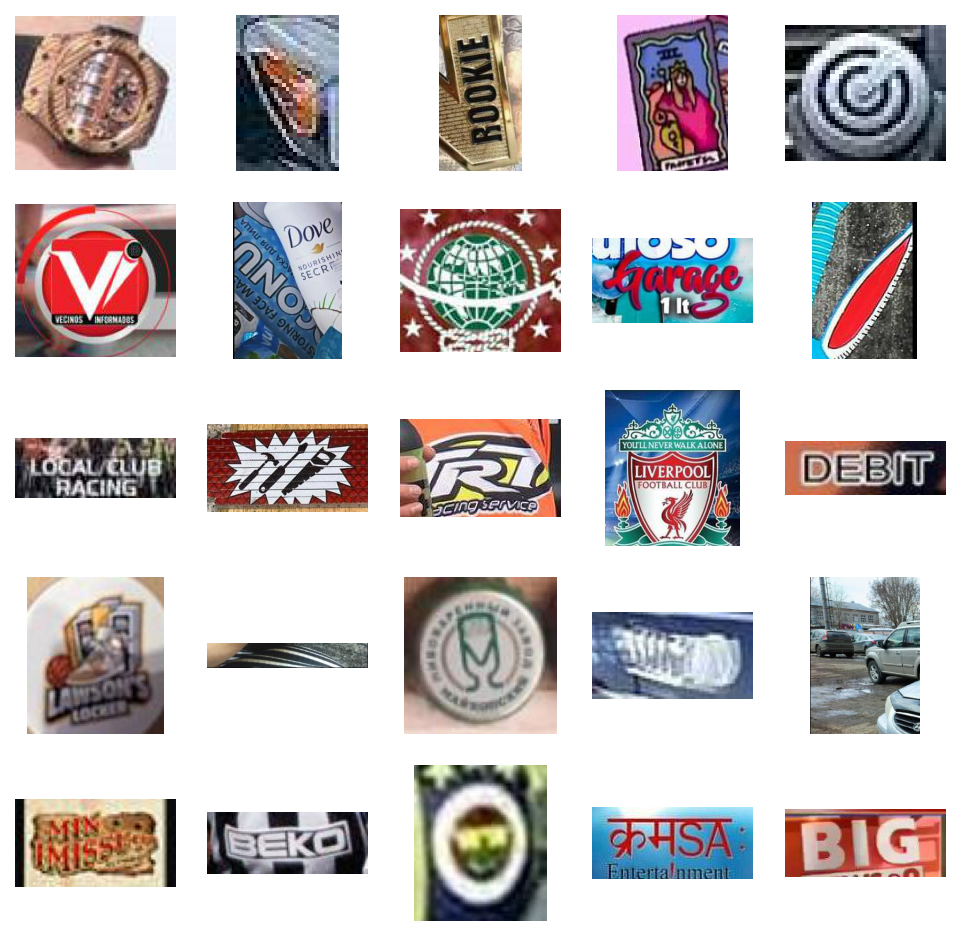

In [53]:
display_images(df[(df.entropy > df.entropy.quantile(q=0.95)) & (df.ocr != '[]')], 5, 5)

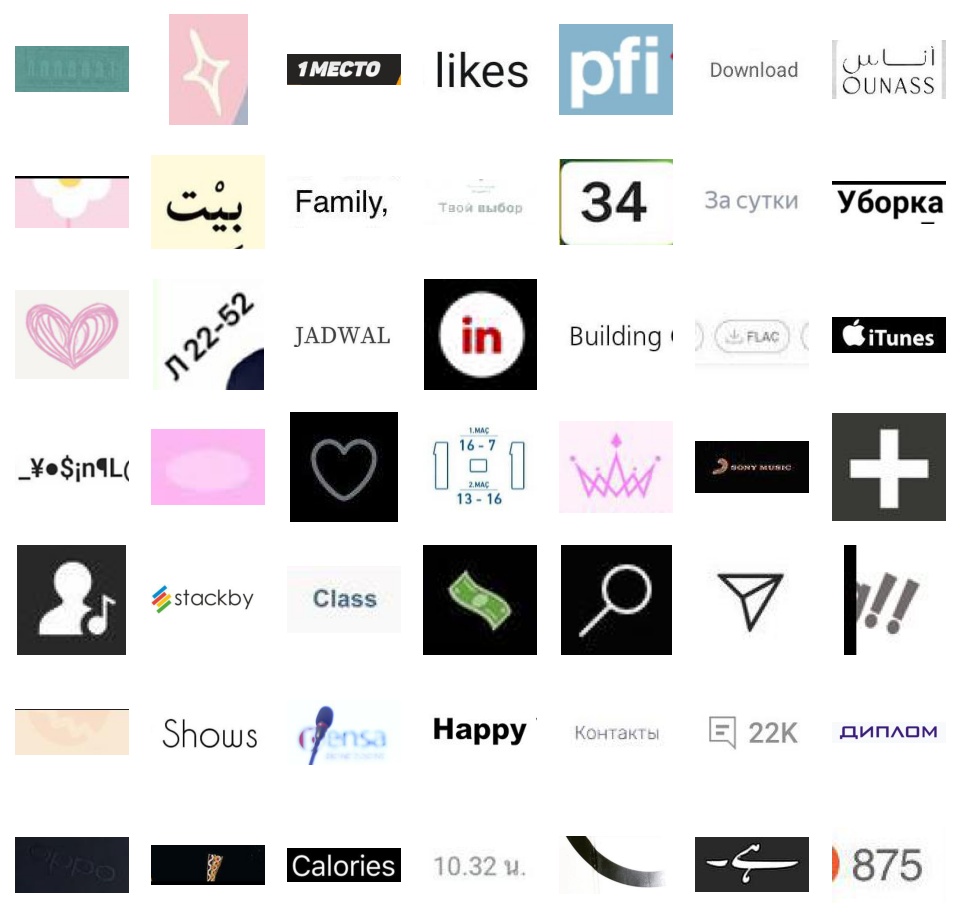

In [52]:
display_images(df[df.entropy < df.entropy.quantile(q=0.05)], 7, 7)

In [9]:
df[df.weak_label > -1].groupby("weak_label").count()

Unnamed: 0  group  path  n_images  api_score  api_name
weak_label                                                        
0                  369    369   369       369        369       369
1                 1873   1873  1873      1873       1873      1873

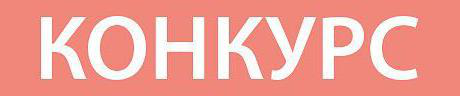

In [70]:
img = Image.open(df.sample(n=1).path.values[0])
img

In [106]:
def plot_text(img, min_conf):
    
    results = pytesseract.image_to_data(img, output_type=Output.DICT)
    # loop over each of the individual text localizations
    outputs = []
    for i in range(0, len(results["text"])):
        # extract the bounding box coordinates of the text region from
        # the current result
        x = results["left"][i]
        y = results["top"][i]
        w = results["width"][i]
        h = results["height"][i]
        # extract the OCR text itself along with the confidence of the
        # text localization
        text = results["text"][i]
        conf = int(results["conf"][i])
        
        if conf > min_conf:
            
            outputs.append((text, (x, y, w, h)))
            # display the confidence and text to our terminal
            #print("Confidence: {}".format(conf))
            #print("Text: {}".format(text))
            #print("")
            # strip out non-ASCII text so we can draw the text on the image
            # using OpenCV, then draw a bounding box around the text along
            # with the text itself
            #text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
            #cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            #cv2.putText(img, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
            #    1.2, (0, 0, 255), 3)
            
    return outputs

In [102]:
df

Unnamed: 0  group                                               path  \
2797         2797   2915  test_task_logo_dataset/feed596f-0893-47c6-8156...   
21729       21729  23907  test_task_logo_dataset/2f6dee24-4418-438c-b8e2...   
8707         8707   9259  test_task_logo_dataset/7b49f2ff-dcd1-49e4-8edb...   
30505       30505  34268  test_task_logo_dataset/30230c74-6a4e-4a41-bd01...   
3099         3099   3235  test_task_logo_dataset/9497ea6a-3e33-4455-8cfb...   
...           ...    ...                                                ...   
12088       12088  12960  test_task_logo_dataset/b48faaad-48a5-479b-a38a...   
25945       25945  28866  test_task_logo_dataset/22f31592-ee02-461c-b01f...   
24922       24922  27669  test_task_logo_dataset/2deca010-08b8-4f9d-bddf...   
19858       19858  21724  test_task_logo_dataset/8d7fa911-3b16-419e-b82e...   
13686       13686  14732  test_task_logo_dataset/ebff7b75-f7b6-459e-b282...   

       n_images  api_score api_name  weak_label  entropy_r  entropy_g  \
2797          1       -1.0       -1          -1   0.000000   0.000000   
21729         1       -1.0       -1          -1   0.989610   0.956135   
8707          1       -1.0       -1          -1   1.043702   0.981002   
30505         1       -1.0       -1          -1   1.064124   0.856394   
3099          1       -1.0       -1          -1   0.993385   1.003255   
...         ...        ...      ...         ...        ...        ...   
12088         1       -1.0       -1          -1   5.388961   5.464780   
25945         1       -1.0       -1          -1   5.468097   5.468962   
24922         1       -1.0       -1          -1   5.446546   5.473996   
19858         1       -1.0       -1          -1   5.468868   5.472851   
13686         1       -1.0       -1          -1   5.490151   5.453237   

       entropy_b    h     w   entropy  
2797    0.000000    3    24  0.000000  
21729   0.958199   50   353  0.967981  
8707    0.933905   47    56  0.986203  
30505   1.064124   62   188  0.994881  
3099    1.012575  441   269  1.003072  
...          ...  ...   ...       ...  
12088   5.526125  607  1151  5.459955  
25945   5.467702   58   122  5.468254  
24922   5.490587   80    90  5.470376  
19858   5.477188   77    53  5.472969  
13686   5.486332  108   175  5.476573  

[32158 rows x 13 columns]

In [101]:
plot_text(np.array(img), 50)

[]

In [116]:
df["ocr"] = 0
with tqdm(ascii=True, leave=False, total=len(df)) as bar:
    for index, row in df.iterrows():
        df.loc[index, "ocr"] = str(plot_text(np.array(Image.open(row.path)), 50))
        bar.update()

KeyboardInterrupt: 

In [118]:
import ast

In [120]:
column = df[df.ocr != 0].ocr

In [121]:
column

2797                                                    []
21729                                                   []
8707                                                    []
30505                           [('fi', (70, 18, 18, 26))]
3099                                                    []
                               ...                        
19874    [('SILVIA', (33, 9, 121, 45)), ('RIBEIRO', (17...
13415                            [('', (12, 10, 127, 82))]
25532                                                   []
2998                      [('RUBBISH', (28, 21, 306, 83))]
28498                            [('3a', (13, 7, 31, 22))]
Name: ocr, Length: 1232, dtype: object

In [122]:
column.reset_index()

index                                                ocr
0      2797                                                 []
1     21729                                                 []
2      8707                                                 []
3     30505                         [('fi', (70, 18, 18, 26))]
4      3099                                                 []
...     ...                                                ...
1227  19874  [('SILVIA', (33, 9, 121, 45)), ('RIBEIRO', (17...
1228  13415                          [('', (12, 10, 127, 82))]
1229  25532                                                 []
1230   2998                   [('RUBBISH', (28, 21, 306, 83))]
1231  28498                          [('3a', (13, 7, 31, 22))]

[1232 rows x 2 columns]

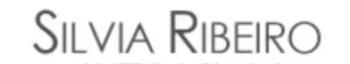

In [127]:
Image.open(df.loc[19874].path)

In [102]:
df = pd.read_csv("dataset_with_weak_label_entropy.csv")
labeled = pd.read_csv("labeled_part.csv")

In [107]:
z = labeled.merge(df, on="path", how="right")

In [109]:
z = z.drop(columns=["Unnamed: 0_x", "Unnamed: 0_y"])

In [111]:
z.to_csv("dataset_with_all_label.csv", index=False)

In [112]:
z

label                                               path  group  \
0       NaN  test_task_logo_dataset/feed596f-0893-47c6-8156...   2915   
1       NaN  test_task_logo_dataset/2f6dee24-4418-438c-b8e2...  23907   
2       NaN  test_task_logo_dataset/7b49f2ff-dcd1-49e4-8edb...   9259   
3       NaN  test_task_logo_dataset/30230c74-6a4e-4a41-bd01...  34268   
4       NaN  test_task_logo_dataset/9497ea6a-3e33-4455-8cfb...   3235   
...     ...                                                ...    ...   
32154   NaN  test_task_logo_dataset/b48faaad-48a5-479b-a38a...  12960   
32155   NaN  test_task_logo_dataset/22f31592-ee02-461c-b01f...  28866   
32156   NaN  test_task_logo_dataset/2deca010-08b8-4f9d-bddf...  27669   
32157   NaN  test_task_logo_dataset/8d7fa911-3b16-419e-b82e...  21724   
32158   NaN  test_task_logo_dataset/ebff7b75-f7b6-459e-b282...  14732   

       n_images  api_score api_name  weak_label                         ocr  \
0             1       -1.0       -1          -1                          []   
1             1       -1.0       -1          -1                          []   
2             1       -1.0       -1          -1                          []   
3             1       -1.0       -1          -1  [('fi', (70, 18, 18, 26))]   
4             1       -1.0       -1          -1                          []   
...         ...        ...      ...         ...                         ...   
32154         1       -1.0       -1          -1      [('', (0, 0, 0, 607))]   
32155         1       -1.0       -1          -1                          []   
32156         1       -1.0       -1          -1                          []   
32157         1       -1.0       -1          -1                          []   
32158         1       -1.0       -1          -1    [('', (0, 0, 175, 108))]   

       entropy_r  entropy_g  entropy_b    h     w   entropy  \
0       0.000000   0.000000   0.000000    3    24  0.000000   
1       0.989610   0.956135   0.958199   50   353  0.967981   
2       1.043702   0.981002   0.933905   47    56  0.986203   
3       1.064124   0.856394   1.064124   62   188  0.994881   
4       0.993385   1.003255   1.012575  441   269  1.003072   
...          ...        ...        ...  ...   ...       ...   
32154   5.388961   5.464780   5.526125  607  1151  5.459955   
32155   5.468097   5.468962   5.467702   58   122  5.468254   
32156   5.446546   5.473996   5.490587   80    90  5.470376   
32157   5.468868   5.472851   5.477188   77    53  5.472969   
32158   5.490151   5.453237   5.486332  108   175  5.476573   

       weak_label_entropy  
0                       0  
1                       0  
2                       0  
3                       0  
4                       0  
...                   ...  
32154                  -1  
32155                  -1  
32156                  -1  
32157                  -1  
32158                  -1  

[32159 rows x 15 columns]